## Quality filtering for sequencing data

Uptil now, we have been using all reads without taking the information from the basecaller's quality threshold into clustering. I wish to examine the following

1. What is the difference in the IDS rates in a normal sequencing experiment as a function of the quality of the read?
2. Can we isolate the errors introduced by synthesis by filtering out low quality reads? 

### IDS rates for different quality reads
Testing on the barcoded run (cleaner data) - 200125

In [1]:
import Bio
from utils import get_fastq_records, reverse_complement
import os
import numpy as np
import matplotlib.pyplot as plt
from Levenshtein import ratio

In [38]:
original_sequence = "AGTGCAACAAGTCAATCCGTTTCACCAAGGAGGCCTCCTGGAACAATGAATTATGGCGCCAAGACATGGTGGATCCTAACTGGAGCGCCGACCTGGAGATACGATCCGGAGGTGCCAGGATCGTCTCTGGAACGCTCCGAAAGTCTTGTT"

In [39]:
fq_filepath = r"C:\Users\Parv\Doc\RA\Projects\sequencing_data\sequencingData\020425 - Full Circle 150 NC 4.5S Coupling Time\xaa\xaa"

In [40]:
records = get_fastq_records(fq_filepath)

200000it [00:05, 39506.06it/s]


In [41]:
avg_qualities = [np.mean(i.letter_annotations["phred_quality"]) for i in records]

Text(0, 0.5, 'Number of reads')

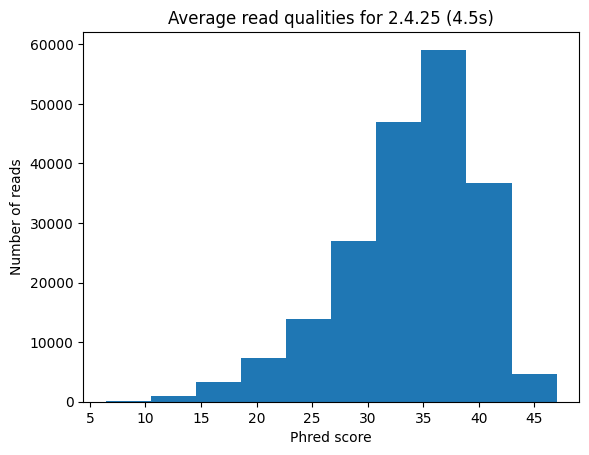

In [44]:
plt.hist(avg_qualities)
plt.title("Average read qualities for 2.4.25 (4.5s)")
plt.xlabel("Phred score")
plt.ylabel("Number of reads")

In [45]:
from difflib import SequenceMatcher

def get_prediction_errors(original, predicted):
    sm = SequenceMatcher(None, original, predicted)
    errors = [0] * len(predicted)  # Assume all bases are correct initially

    for tag, i1, i2, j1, j2 in sm.get_opcodes():
        if tag == 'equal':
            continue
        elif tag == 'replace':
            for j in range(j1, j2):
                errors[j] = 1
        elif tag == 'insert':
            for j in range(j1, j2):
                errors[j] = 1
        elif tag == 'delete':
            pass

    return errors


In [46]:
from Levenshtein import editops, distance
from tqdm import tqdm
from strand_reconstruction import align

errors = []
qualities = []

for record in tqdm(records[:10000]):

    qscore = record.letter_annotations["phred_quality"]
    strand = str(record.seq)
    rev_strand = reverse_complement(strand)

    if ratio(strand, original_sequence) < ratio(rev_strand, original_sequence):
        strand = rev_strand
        qscore = qscore[::-1]

    etops = get_prediction_errors(original_sequence, strand)

    for i, j in zip(etops, qscore):
        errors.append(i)
        qualities.append(j)


100%|██████████| 10000/10000 [00:24<00:00, 411.37it/s]


In [47]:

import pandas as pd

df = pd.DataFrame(
    {
        "quality": qualities,
        "error": errors
     }
)

In [49]:
quality_thresholds = np.arange(5, 50, 5)


for threshold in quality_thresholds:
    filtered_df = df.loc[df['quality'] > threshold]

    error_probability = filtered_df['error'].value_counts()[0] / (filtered_df['error'].value_counts()[0] + filtered_df['error'].value_counts()[1])
    print(threshold, error_probability)

5 0.9113077793718201
10 0.9155415598129432
15 0.9174909663438688
20 0.9185709112627505
25 0.9193455541301196
30 0.9200075240943539
35 0.9203543873958602
40 0.9214024140274418
45 0.9217902742407705


In [ ]:
filtered_df['error'].value_counts()[0]

error
0    344796
1     11789
Name: count, dtype: int64

Text(0.5, 1.0, 'Correct base quality distribution')

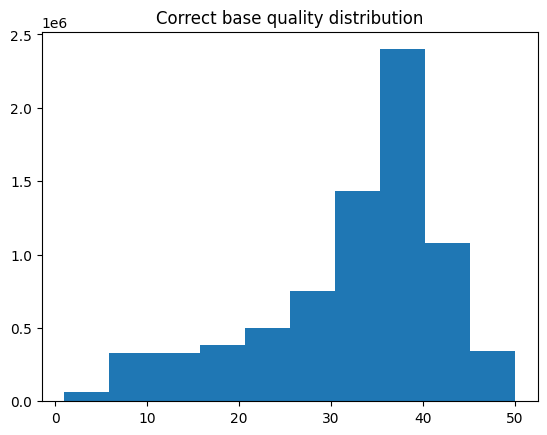

In [39]:
plt.hist(correct_base_qualities)
plt.title("Correct base quality distribution")

In [ ]:
print(np.mean(incorrect_base_qualities))

26.799944958107005


In [41]:
print(np.mean(correct_base_qualities))

32.59965331928415


In [50]:
from evaluation import count_ids_errors
from tqdm.notebook import tqdm
# Checking ids rates for both reads

quality_score = []

subsitutions = []
insertions = []
deletions = []

for record in tqdm(records):

    strand = str(record.seq)
    rev_strand = reverse_complement(strand)

    if ratio(strand, original_sequence) < ratio(rev_strand, original_sequence):
        strand = rev_strand

    ids = count_ids_errors(strand, original_sequence)
    subsitutions.append(ids["Substitutions"])
    deletions.append(ids["Deletions"])
    insertions.append(ids["Insertions"])
    quality_score.append(
        np.mean(record.letter_annotations["phred_quality"]))
    

  0%|          | 0/200000 [00:00<?, ?it/s]

In [53]:
import pandas as pd

df = pd.DataFrame({
    "subsitutions": subsitutions,
    "insertions": insertions,
    "deletions": deletions,
    "quality": quality_score
    })

In [60]:
lens = [len(i.seq) for i in records]

(array([1.34200e+03, 1.62694e+05, 3.52350e+04, 1.26000e+02, 1.89000e+02,
        1.05000e+02, 6.30000e+01, 1.31000e+02, 1.03000e+02, 1.20000e+01]),
 array([ 50.,  89., 128., 167., 206., 245., 284., 323., 362., 401., 440.]),
 <BarContainer object of 10 artists>)

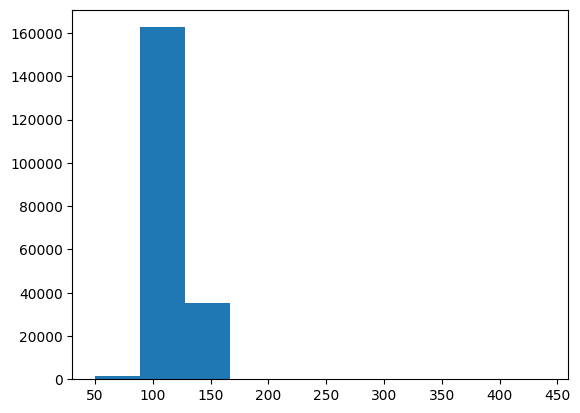

In [61]:
plt.hist(lens)

In [54]:
df.corr()

,subsitutions,insertions,deletions,quality
subsitutions,1.000000,-0.253734,0.372890,-0.169464
insertions,-0.253734,1.000000,-0.196618,0.039277
deletions,0.372890,-0.196618,1.000000,-0.062805
quality,-0.169464,0.039277,-0.062805,1.000000


1. Moderately, higher quality scores lead to lower subsitutions
2. Very weakly, higher quality scores lead to lower insertions

Let's check the other sequences

In [78]:
# Average quality per/aligned base
# Average prediction error (IDS)